In [2]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
import rul 
%load_ext autoreload
%autoreload

# Load Data

In [3]:
kaggle_data = pd.read_csv("C:\\Users\\I539001\\OneDrive - SAP SE\\PA2\\AL\\FeedbackBoost\\Data\\Kaggle_Plant.csv")

In [4]:
Data_id = "Kaggel_plant"

In [5]:
kaggle_data.head()

,Unnamed: 0,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,...,L_10,A_5,B_5,C_5,ts_int,cnt_per_rtf,RUL,RUL_pw,phase,IMM_FAILURE
0,1,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,...,-65.524273,-100.0,-100.0,-100.0,1,51671,51671,120,1,0
1,2,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,...,-65.524273,-100.0,-100.0,-100.0,2,51671,51670,120,1,0
2,3,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,...,-71.139518,-100.0,-100.0,-100.0,3,51671,51669,120,1,0
3,4,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,...,-68.708337,-100.0,-100.0,-100.0,4,51671,51668,120,1,0
4,5,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,...,-67.030037,-100.0,-100.0,-100.0,5,51671,51667,120,1,0


In [6]:
kaggel_data_uncleaned = kaggle_data

# Some Exploratory Analysis

In [7]:
kaggle_data['rtf_id'].unique()

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

In [8]:
data_16 = kaggle_data[kaggle_data['rtf_id'] == 16]

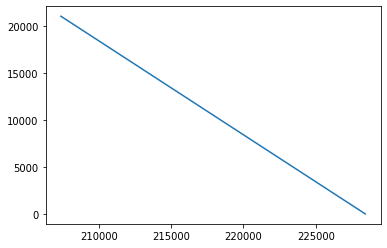

In [9]:
plt.plot(data_16["RUL"])

<Figure size 432x288 with 0 Axes>

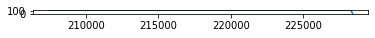

In [10]:
fig = plt.figure()
# plt.rcParams["figure.figsize"] = (50,20)
fig, ax = plt.subplots()

ratio = 2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_16["RUL_pw"])


In [11]:
data_8 = kaggle_data[kaggle_data['rtf_id'] == 8]

<Figure size 432x288 with 0 Axes>

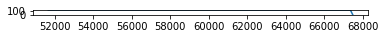

In [12]:
fig = plt.figure()
# plt.rcParams["figure.figsize"] = (50,10)
fig, ax = plt.subplots()

ratio = 2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_8["RUL_pw"])

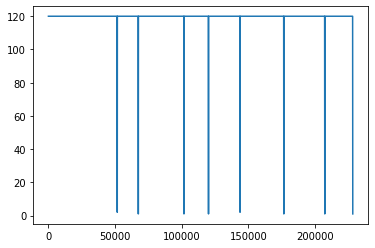

In [13]:
plt.plot(kaggle_data["RUL_pw"])

In [14]:
data_16["RUL_pw"].unique()

array([120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108,
       107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,
        94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,
        81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,
        68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,
        55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,  43,
        42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,
        29,  28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,
        16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,
         3,   2,   1], dtype=int64)

In [15]:
data_16["RUL_pw"].value_counts()

120    20902
119        1
32         1
33         1
34         1
       ...  
85         1
86         1
87         1
88         1
1          1
Name: RUL_pw, Length: 120, dtype: int64

In [16]:
data_8 = kaggle_data[kaggle_data['rtf_id'] == 8]
data_8["RUL"].iloc[-1]

1

In [17]:
# we only have 8 rtfs -> very few amount of data
rtf_ids = kaggle_data['rtf_id'].unique() # very few amount of data compared to cmaps (260 unique engine_ids alone in train set)
rtf_ids
# cross validation as solution to "zu wenig data"

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

# Data Preparation

In [18]:
original_rul_pw = kaggle_data["RUL_pw"]

In [19]:
kaggle_data= kaggle_data.drop(['Unnamed: 0', 'ts_int', 'cnt_per_rtf','phase','IMM_FAILURE'], axis=1) 
# run to failure id: z.B engine_id 

In [20]:
#define train dataset and test dataset: first, without cross validation. Just manually defining
train_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[:6]))]

In [21]:
train_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL,RUL_pw
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51671,120
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51670,120
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,51669,120
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,51668,120
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,51667,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,14,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,...,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,5,5
176654,14,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,...,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,4,4
176655,14,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,...,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,3,3
176656,14,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,...,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,2,2


In [22]:
train_data_with_original_pw_rul = train_data.copy()

In [23]:
train_data_original_rul_pw = train_data["RUL_pw"] 

In [24]:
train_data = train_data.drop(["RUL_pw"], axis = 1)

In [25]:
train_RUL_per_rtf_id =  extract_RUL_per_rtf_id(train_data, rul_column_name= "RUL")

In [26]:
train_RUL_per_rtf_id

,rtf_id,rul_per_rtf_id
0,7,2
1,8,1
2,9,1
3,11,1
4,13,2
5,14,1


In [27]:
y_train_RUL_per_cycle = train_data['RUL']
x_train_data = train_data.loc[:, train_data.columns!='RUL']

In [28]:
test_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[6:]))]

In [29]:
test_data_with_original_pw_rul = test_data.copy()

In [30]:
test_data_original_rul_pw = test_data["RUL_pw"]

In [31]:
test_data = test_data.drop(["RUL_pw"], axis = 1)

In [32]:
train_data.head()

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.0,-100.0,51671
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.0,-100.0,51670
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.0,-100.0,51669
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.0,-100.0,51668
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.0,-100.0,51667


In [33]:
test_RUL_per_rtf_id = extract_RUL_per_rtf_id(test_data, rul_column_name= "RUL")

In [34]:
test_RUL_per_rtf_id

,rtf_id,rul_per_rtf_id
0,15,1
1,16,1


In [35]:
y_test_RUL_per_cycle = test_data['RUL']
x_test_data = test_data.loc[:, test_data.columns!='RUL']


In [36]:
x_test_data.head()

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_4,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-97.493393,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-75.069834,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-50.426569,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,4.552677,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,73.363560,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0


In [37]:
x_train_data.columns

Index(['rtf_id', 'cycle', 'L_1', 'L_2', 'A_1', 'A_2', 'B_1', 'B_2', 'C_1',
       'C_2', 'A_3', 'A_4', 'B_3', 'B_4', 'C_3', 'C_4', 'L_3', 'L_4', 'L_5',
       'L_6', 'L_7', 'L_8', 'L_9', 'L_10', 'A_5', 'B_5', 'C_5'],
      dtype='object')

## Computing Remaining Useful Life

In [38]:
import importlib
import rul
importlib.reload(rul)


<module 'rul' from 'c:\\Users\\I539001\\OneDrive - SAP SE\\PA2\\AL\\AutoRUL\\rul.py'>

In [39]:
test_RUL_per_rtf_id = test_RUL_per_rtf_id["rul_per_rtf_id"]
train_RUL_per_rtf_id = train_RUL_per_rtf_id["rul_per_rtf_id"]

In [40]:
train_RUL_per_rtf_id

0    2
1    1
2    1
3    1
4    2
5    1
Name: rul_per_rtf_id, dtype: int64

In [41]:
# x_train_data1

In [42]:
test0  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=8, epochs= 30)


the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


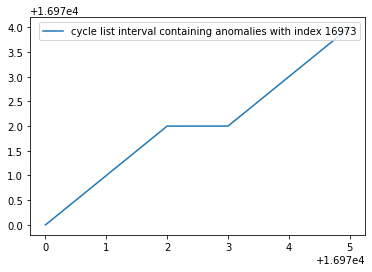

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


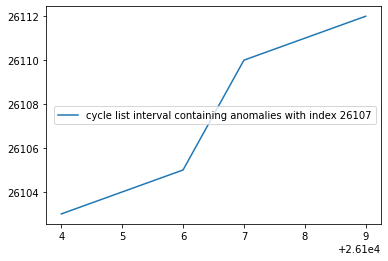

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


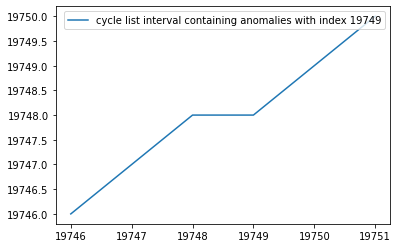

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


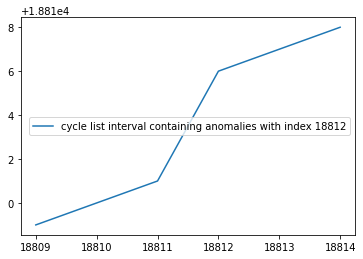

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


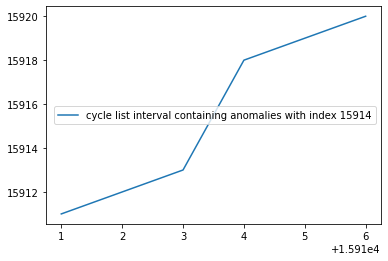

training (176658, 23) (176658,)
testing (51754, 23) (51754,)


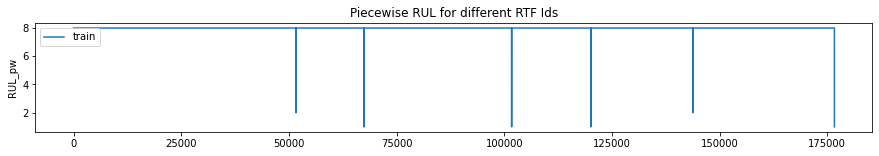

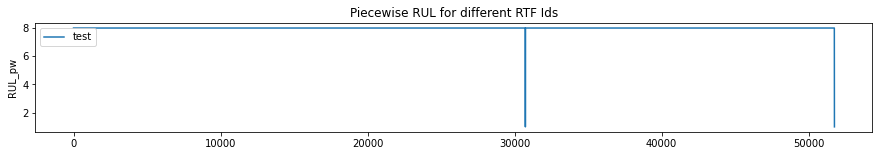

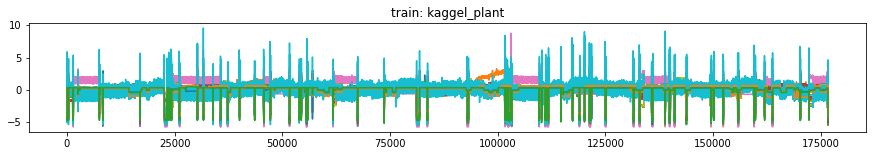

valid Configuration!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 5, 12, 1, 10)     6740      
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 12, 1, 10)     40        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None,

(   y_batch_test  y_batch_pred_test
 0           1.0           7.994960
 1           1.0           7.983921,
         y_batch_train  y_batch_train
 0                 8.0       7.994984
 1                 8.0       7.994927
 2                 8.0       7.995049
 3                 8.0       7.994921
 4                 8.0       7.994964
 ...               ...            ...
 176539            5.0       7.984658
 176540            4.0       7.983690
 176541            3.0       7.985512
 176542            2.0       7.988879
 176543            1.0       7.990623
 
 [176544 rows x 2 columns])

In [48]:
test0.auto_rul()

In [45]:
# x_train1

In [46]:
# extract_RUL_per_rtf_id(x_train1)

In [44]:
test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=8, epochs= 30)
test.auto_rul()

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


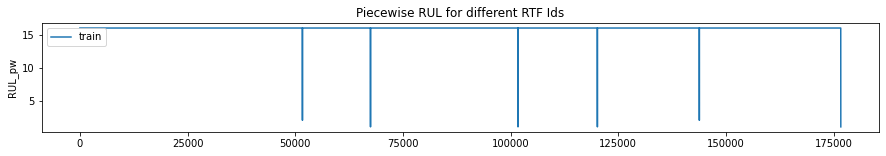

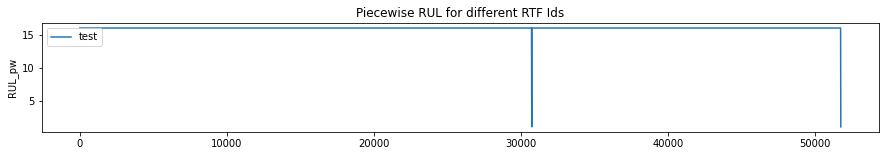

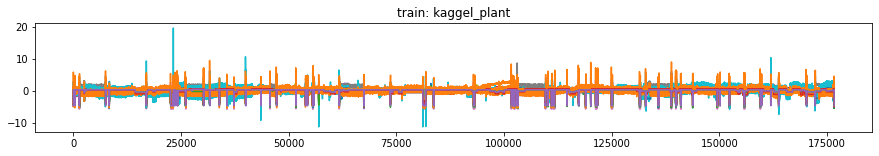

valid Configuration!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_2 (ModuleWra  (None, 5, 12, 1, 10)     6980      
 pper)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_3 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_3 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0          15.760289
 1           1.0          15.042830,
         y_batch_train  y_batch_train
 0                16.0      15.794313
 1                16.0      15.801121
 2                16.0      15.797369
 3                16.0      15.788224
 4                16.0      15.778408
 ...               ...            ...
 176539            5.0      15.687199
 176540            4.0      15.685656
 176541            3.0      15.689463
 176542            2.0      15.641682
 176543            1.0      15.531469
 
 [176544 rows x 2 columns])

In [88]:
test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=16, epochs= 30)
test.auto_rul()

training (176658, 22) (176658,)
testing (51754, 22) (51754,)


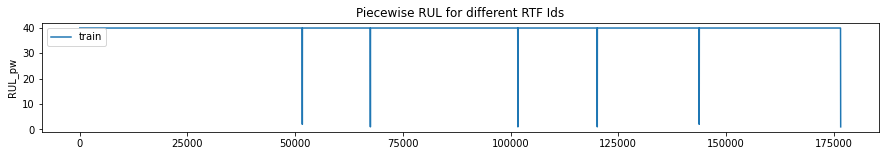

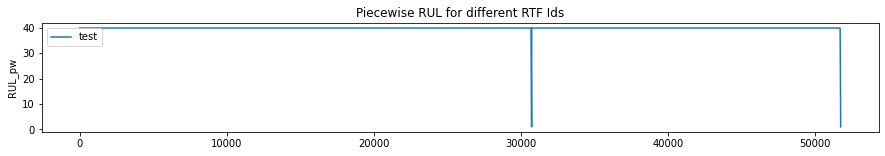

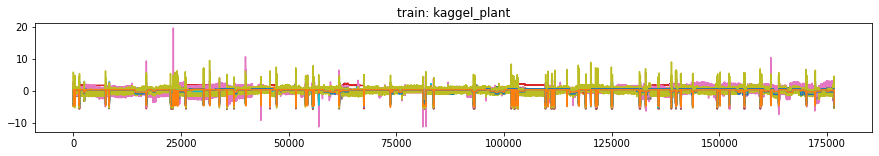

valid Configuration!
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_4 (ModuleWra  (None, 5, 12, 1, 10)     6620      
 pper)                                                           
                                                                 
 batch_normalization_4 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_5 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_5 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0          39.886433
 1           1.0          38.577427,
         y_batch_train  y_batch_train
 0                40.0      39.922234
 1                40.0      39.922054
 2                40.0      39.938183
 3                40.0      39.956615
 4                40.0      39.953945
 ...               ...            ...
 176539            5.0      39.591522
 176540            4.0      39.383057
 176541            3.0      39.128101
 176542            2.0      38.877304
 176543            1.0      38.651676
 
 [176544 rows x 2 columns])

In [89]:
test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=40, epochs= 30)
test.auto_rul()

In [90]:
# test.compute_piecewise_linear_rul()

In [42]:
import importlib
import rul
importlib.reload(rul)

<module 'rul' from 'c:\\Users\\I539001\\OneDrive - SAP SE\\PA2\\AL\\AutoRUL\\rul.py'>

In [92]:
test2  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=8, epochs= 30)

training (176658, 23) (176658,)
testing (51754, 23) (51754,)


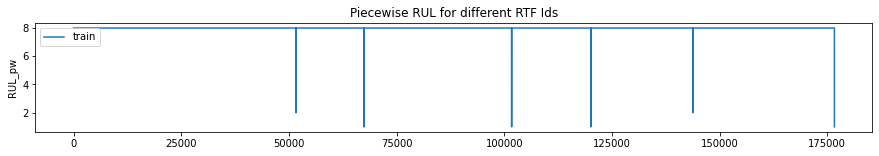

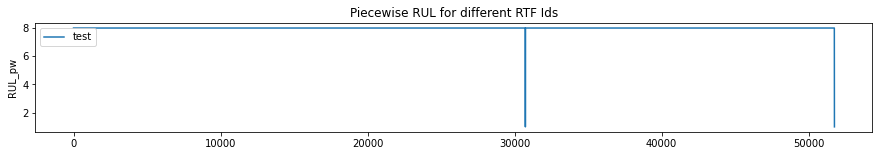

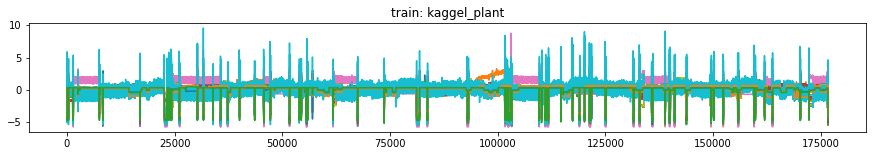

valid Configuration!
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_6 (ModuleWra  (None, 5, 12, 1, 10)     6740      
 pper)                                                           
                                                                 
 batch_normalization_6 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_7 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_7 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0           7.977491
 1           1.0           7.928466,
         y_batch_train  y_batch_train
 0                 8.0       7.977269
 1                 8.0       7.977162
 2                 8.0       7.976396
 3                 8.0       7.975879
 4                 8.0       7.975336
 ...               ...            ...
 176539            5.0       7.964271
 176540            4.0       7.962786
 176541            3.0       7.962413
 176542            2.0       7.963134
 176543            1.0       7.963618
 
 [176544 rows x 2 columns])

In [93]:
test2.auto_rul()

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


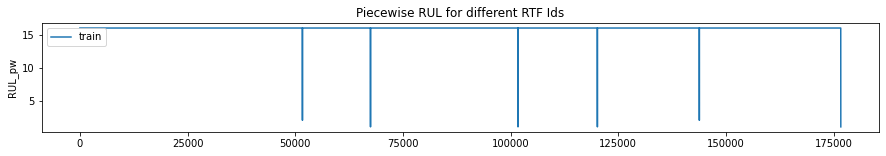

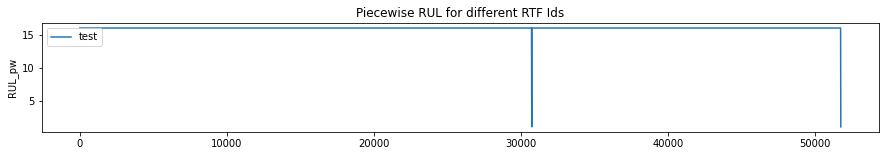

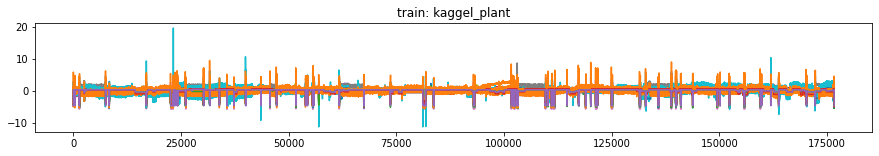

valid Configuration!
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_8 (ModuleWra  (None, 5, 12, 1, 10)     6980      
 pper)                                                           
                                                                 
 batch_normalization_8 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_9 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_9 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0          15.986142
 1           1.0          15.986644,
         y_batch_train  y_batch_train
 0                16.0      15.998645
 1                16.0      16.000856
 2                16.0      15.994642
 3                16.0      15.986619
 4                16.0      15.994960
 ...               ...            ...
 176539            5.0      16.015657
 176540            4.0      16.037281
 176541            3.0      16.025679
 176542            2.0      16.003828
 176543            1.0      15.997103
 
 [176544 rows x 2 columns])

In [94]:
test2  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=16, epochs= 30)
test2.auto_rul()

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


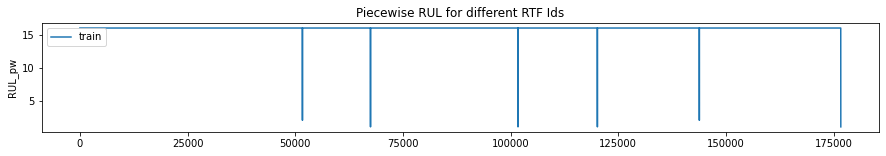

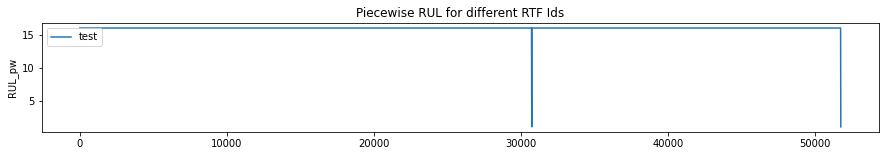

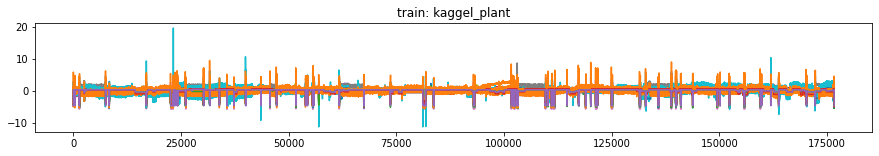

valid Configuration!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_10 (ModuleWr  (None, 5, 12, 1, 10)     6980      
 apper)                                                          
                                                                 
 batch_normalization_10 (Bat  (None, 5, 12, 1, 10)     40        
 chNormalization)                                                
                                                                 
 module_wrapper_11 (ModuleWr  (None, 8, 1, 20)         18160     
 apper)                                                          
                                                                 
 batch_normalization_11 (Bat  (None, 8, 1, 20)         80        
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0          15.932209
 1           1.0          15.639988,
         y_batch_train  y_batch_train
 0                16.0      15.940213
 1                16.0      15.947474
 2                16.0      15.953399
 3                16.0      15.955200
 4                16.0      15.960189
 ...               ...            ...
 176539            5.0      15.882438
 176540            4.0      15.849278
 176541            3.0      15.830243
 176542            2.0      15.814494
 176543            1.0      15.801179
 
 [176544 rows x 2 columns])

In [95]:
test3  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=16, epochs= 30)
test3.auto_rul()

In [87]:
# x_test_data4

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


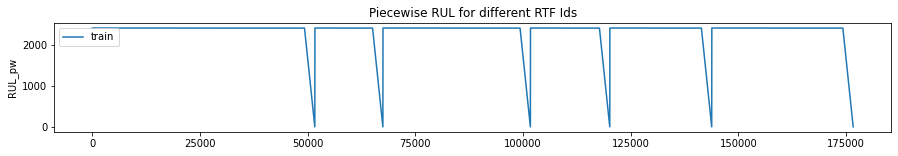

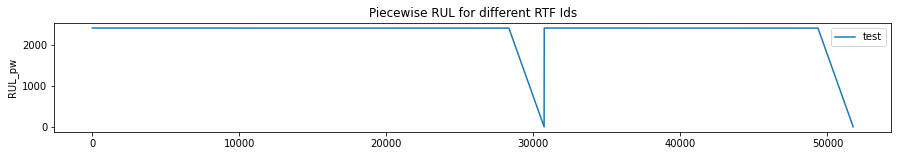

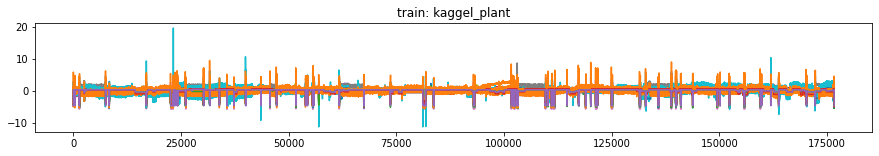

valid Configuration!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_2 (ModuleWra  (None, 5, 12, 1, 10)     6980      
 pper)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_3 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_3 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (Non

In [88]:
test4  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life= 2400, epochs= 30)
test4.auto_rul()

bis zur hälfte von cycle length ausprobierne

In [46]:


test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=7000, epochs= 30)

In [43]:
# x_train_data

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


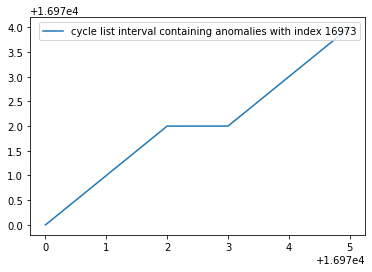

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


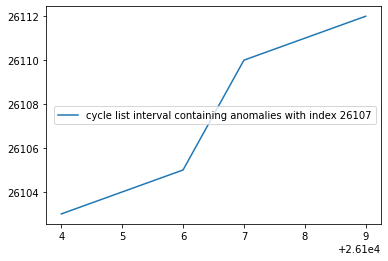

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


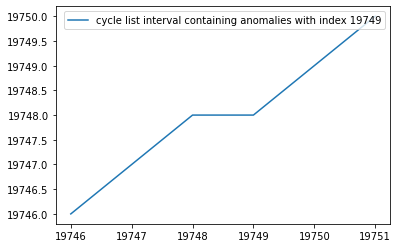

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


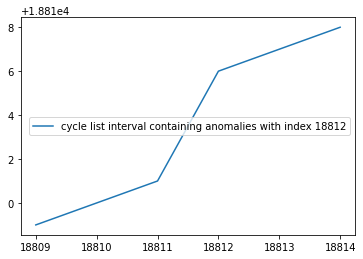

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


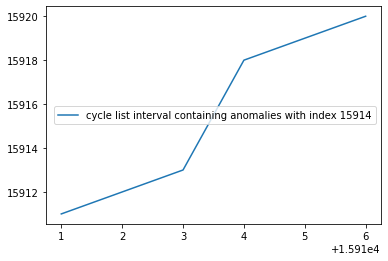

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


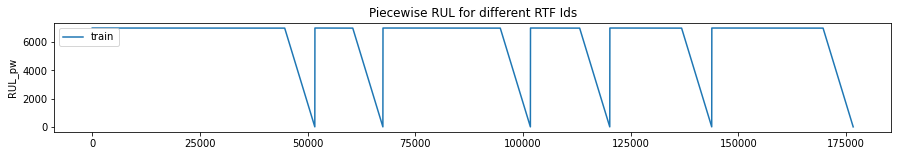

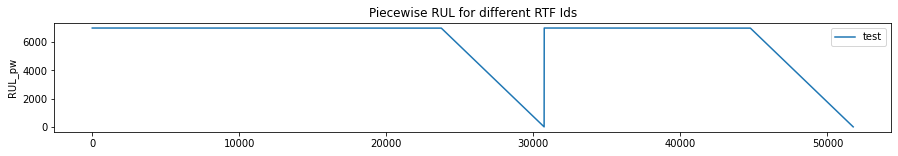

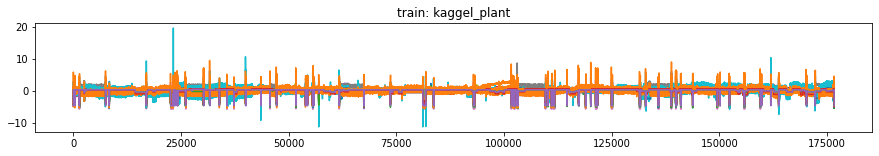

valid Configuration!
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_4 (ModuleWra  (None, 5, 12, 1, 10)     6980      
 pper)                                                           
                                                                 
 batch_normalization_4 (Batc  (None, 5, 12, 1, 10)     40        
 hNormalization)                                                 
                                                                 
 module_wrapper_5 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_5 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (Non

(   y_batch_test  y_batch_pred_test
 0           1.0        6125.114746
 1           1.0        6806.025879,
         y_batch_train  y_batch_train
 0              7000.0    6407.693359
 1              7000.0    6438.336426
 2              7000.0    6386.173340
 3              7000.0    6384.063477
 4              7000.0    6401.908203
 ...               ...            ...
 176539            5.0    6706.506836
 176540            4.0    6721.528320
 176541            3.0    6718.486816
 176542            2.0    6708.579590
 176543            1.0    6723.683105
 
 [176544 rows x 2 columns])

In [47]:
test.auto_rul()

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


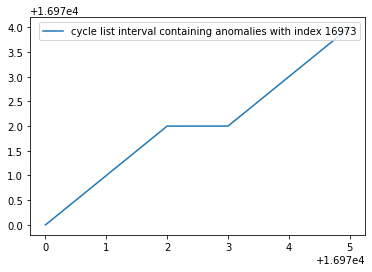

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


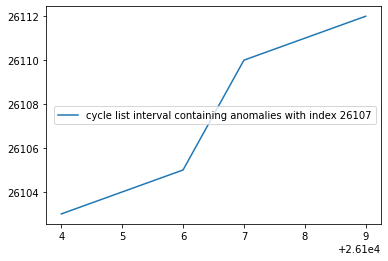

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


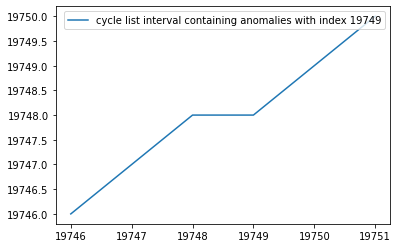

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


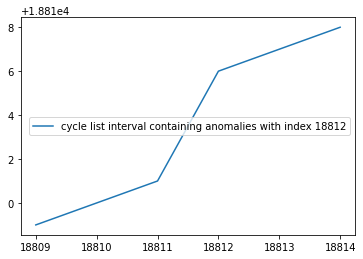

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


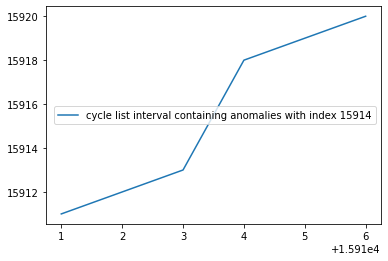

In [76]:
train_df, test_df = test.compute_piecewise_linear_rul()

In [77]:
type(train_df)

pandas.core.frame.DataFrame

In [78]:
train_df

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL_pw
0,1,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,120
1,1,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,120
2,1,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,120
3,1,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,120
4,1,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,6,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,...,-73.534037,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,5
176654,6,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,...,-73.534037,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,4
176655,6,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,...,-73.534037,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,3
176656,6,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,...,-73.534037,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,2


In [79]:
train_df_without_rtf_id = train_df.iloc[:, 1:]

In [80]:
test_df_without_rtf_id = test_df.iloc[:,1:]

In [81]:
train_df_without_rtf_id

,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,A_3,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL_pw
0,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,-65.697449,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,120
1,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,-65.697449,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,120
2,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,-65.697449,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,120
3,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,-65.697449,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,120
4,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,-65.697449,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,-50.205474,...,-73.534037,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,5
176654,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,-49.073428,...,-73.534037,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,4
176655,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,-46.049469,...,-73.534037,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,3
176656,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,-49.368070,...,-73.534037,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,2


In [82]:
train_data_with_original_pw_rul = train_data_with_original_pw_rul.iloc[:, 1:]

In [83]:
train_data_with_original_pw_rul = train_data_with_original_pw_rul.drop(["RUL"], axis=1)


In [84]:
train_data_with_original_pw_rul.equals(train_df_without_rtf_id) # Die Ergebnisse aus meiner Berechnungen auf den Trainingsdatensatz stimmt mit dem ursprünglichen Datensatz, für den rul_pw berechnet wurde, überein. 

True

In [85]:
test_data_with_original_pw_rul = test_data_with_original_pw_rul.iloc[:, 1:]
test_data_with_original_pw_rul = test_data_with_original_pw_rul.drop(["RUL"], axis=1)


In [86]:
test_df_without_rtf_id

,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,A_3,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL_pw
176658,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,-64.177716,...,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0,120
176659,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,-64.177716,...,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0,120
176660,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,-64.177716,...,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0,120
176661,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,-64.177716,...,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0,120
176662,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,-66.736450,...,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,-24.844354,-51.446073,...,-20.766869,-80.250080,-87.664005,-25.706193,-92.346823,-30.123128,-100.0,-100.0,-100.0,5
228408,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,-24.831247,-47.274560,...,-74.223021,-80.250080,-93.511124,-25.917343,-97.585605,-60.269783,-100.0,-100.0,-100.0,4
228409,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,-24.857461,-46.313096,...,-74.223021,-80.250080,-93.511124,-26.303592,-97.585605,-59.062034,-100.0,-100.0,-100.0,3
228410,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,-24.791926,-48.670233,...,-74.223021,-80.250080,-93.511124,-26.725892,-97.585605,-61.242256,-100.0,-100.0,-100.0,2


In [87]:
test_data_with_original_pw_rul.equals(test_df_without_rtf_id)

True